In [108]:
#!pip install tensorflow
#!pip install seaborn
#!pip install statsmodels

In [109]:
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns

from matplotlib import pyplot as plt


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.metrics import mean_absolute_error

import statsmodels.api as sm

In [110]:
# Carga de los datos

df = pd.read_csv('Completa.csv', sep=',')
df = df.drop(['ID'], axis=1)

In [111]:

df['FECHA/HORA'] = pd.to_datetime(df['FECHA/HORA'], format='%d/%m/%Y %H:%M')
df               = df[['FECHA/HORA','Dia','TOTAL KW', 'TEMPERATURA', 'Feriado', 'Publico']]

In [112]:
df.dtypes

FECHA/HORA     datetime64[ns]
Dia                     int64
TOTAL KW                int64
TEMPERATURA           float64
Feriado                 int64
Publico                 int64
dtype: object

In [113]:
X = df[['Dia', 'TEMPERATURA', 'Feriado', 'Publico']]
y = df['TOTAL KW']

X_train, X_test, y_train, y_test = train_test_split(
                                                    X,
                                                    y.values.reshape(-1,1),
                                                    train_size   = 0.8,
                                                    random_state = 1234,
                                                    shuffle      = True
                                                    )

In [114]:
df.describe()

,Dia,TOTAL KW,TEMPERATURA,Feriado,Publico
count,7246.000000,7.246000e+03,7246.000000,7246.000000,7246.000000
mean,3.996826,3.239203e+09,20.289801,0.039746,416.632211
std,1.994434,2.533855e+09,7.222197,0.195375,533.798793
min,1.000000,1.151528e+06,0.000000,0.000000,0.000000
25%,2.000000,1.442600e+09,15.200000,0.000000,0.000000
50%,4.000000,2.166674e+09,20.200000,0.000000,0.000000
75%,6.000000,5.026291e+09,25.200000,0.000000,784.750000
max,7.000000,9.990856e+09,41.400000,1.000000,2702.000000


In [115]:
def tidy_corr_matrix(corr_mat):
    '''
    Función para convertir una matriz de correlación de pandas en formato tidy
    '''
    corr_mat = corr_mat.stack().reset_index()
    corr_mat.columns = ['variable_1','variable_2','r']
    corr_mat = corr_mat.loc[corr_mat['variable_1'] != corr_mat['variable_2'], :]
    corr_mat['abs_r'] = np.abs(corr_mat['r'])
    corr_mat = corr_mat.sort_values('abs_r', ascending=False)
    
    return(corr_mat)

corr_matrix = df.select_dtypes(include=['float64', 'int']).corr(method='pearson')
tidy_corr_matrix(corr_matrix).head(10)

,variable_1,variable_2,r,abs_r
14,TEMPERATURA,Publico,0.479549,0.479549
22,Publico,TEMPERATURA,0.479549,0.479549
21,Publico,TOTAL KW,0.218472,0.218472
9,TOTAL KW,Publico,0.218472,0.218472
4,Dia,Publico,0.133465,0.133465
20,Publico,Dia,0.133465,0.133465
3,Dia,Feriado,-0.067686,0.067686
15,Feriado,Dia,-0.067686,0.067686
23,Publico,Feriado,0.038040,0.038040
19,Feriado,Publico,0.038040,0.038040


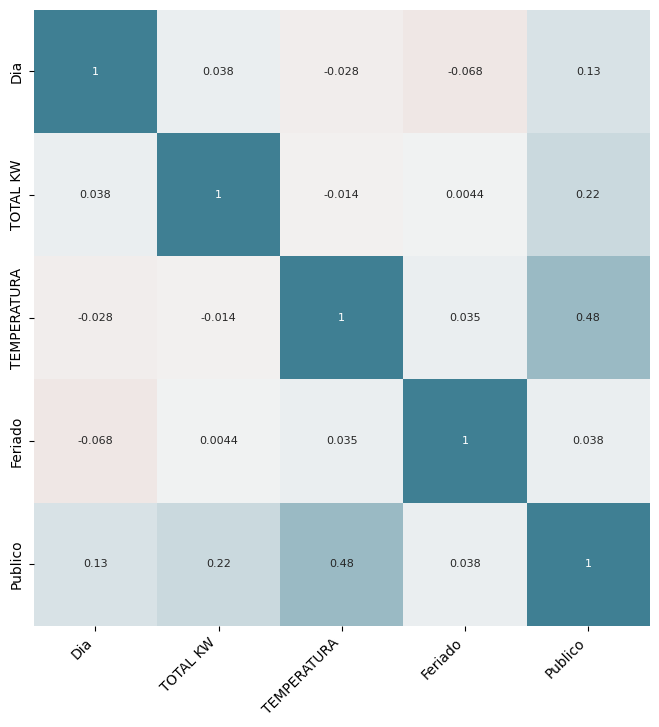

In [116]:
# Heatmap matriz de correlaciones
# ==============================================================================
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))

sns.heatmap(
    corr_matrix,
    annot     = True,
    cbar      = False,
    annot_kws = {"size": 8},
    vmin      = -1,
    vmax      = 1,
    center    = 0,
    cmap      = sns.diverging_palette(20,
                                      220,
                                      n = 200),
    square    = True,
    ax        = ax
)

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation = 45,
    horizontalalignment = 'right',
)

ax.tick_params(labelsize = 10)

In [117]:
# Creamos el objeto de Regresión Linear
modelo = LinearRegression()

# Entrenamos el modelo
modelo.fit(X_train, y_train)

LinearRegression()

In [118]:
print("Coeficiente de determinacion (R^2) entrenamiento: ", modelo.score(X_train, y_train))
print('Coeficiente de determinación (R^2): ', modelo.score(X_test, y_test))
print('Pendiente: ', modelo.coef_)

Coeficiente de determinacion (R^2) entrenamiento:  0.06278758181373545
Coeficiente de determinación (R^2):  0.0779211449925693
Pendiente:  [[-12245934.27714388 -54128033.23534508 -70375483.29324044
    1361743.09633266]]


In [119]:
# Hacemos las predicciones
y_pred = modelo.predict(X_test)

In [120]:
# Con R2

y_pred = modelo.predict(X_test)
lineal_r2 = r2_score(y_test, y_pred)
lineal_comp = pd.DataFrame(list(zip(y_test, y_pred)), columns = ['Actual Values', 'Predicted Values']) 

print('Valor de R2: ' + str(lineal_r2))
print('\nTabla de comparacion: \n\n' + str(lineal_comp))

Valor de R2: 0.0779211449925693

Tabla de comparacion: 

     Actual Values      Predicted Values
0     [5573349276]   [2210962093.588333]
1     [9684575348]   [4277634099.433467]
2     [9624675121]    [4080962219.51103]
3     [9975659294]   [3221961079.332038]
4     [1446959999]   [4223921114.315188]
...            ...                   ...
1445  [2664174509]   [3490687318.809097]
1446  [1746585457]  [3229720938.8461304]
1447  [1401357666]  [3912613766.1951184]
1448   [189359673]  [3075590297.7237797]
1449  [2386422091]  [3098384291.3639355]

[1450 rows x 2 columns]


In [121]:
results = {
    'Prediccion': y_pred[:10],
    'Realidad': y_test[:10]
}

diff = [x-y for x,y in zip(results['Prediccion'], results['Realidad'])]
results['Resultado'] = diff

results['Resultado']

[array([-3.36238718e+09]),
 array([-5.40694125e+09]),
 array([-5.5437129e+09]),
 array([-6.75369821e+09]),
 array([2.77696112e+09]),
 array([-3.88565682e+09]),
 array([2.34402828e+09]),
 array([6.66263194e+08]),
 array([1.68739783e+09]),
 array([-1.83049203e+09])]

In [122]:
# Veamos los coeficienetes obtenidos, En nuestro caso, serán la Tangente
print('Coefficients: \n', modelo.coef_)
# Este es el valor donde corta el eje Y (en X=0)
print('Independent term: \n', modelo.intercept_)
# Puntaje de Varianza. El mejor puntaje es un 1.0
print('Variance score: %.2f' % lineal_r2 )

Coefficients: 
 [[-12245934.27714388 -54128033.23534508 -70375483.29324044
    1361743.09633266]]
Independent term: 
 [3.83622342e+09]
Variance score: 0.08


# PCA

In [123]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train = pd.DataFrame(scaler.fit_transform(X_train), columns = X.columns)

X_test = pd.DataFrame(scaler.transform(X_test), columns = X.columns)

In [124]:
X_train.head()

,Dia,TEMPERATURA,Feriado,Publico
0,-0.995736,-1.879340,-0.201894,-0.784899
1,-0.995736,0.110310,-0.201894,-0.784899
2,-0.995736,-0.953600,-0.201894,0.180580
3,-0.493579,-0.718711,-0.201894,-0.784899
4,-0.493579,1.091317,-0.201894,1.984550


In [125]:
from sklearn.decomposition import PCA
pca = PCA()
X_train = pca.fit_transform(X_train)
pca.explained_variance_ratio_

array([0.37309496, 0.26913778, 0.23328699, 0.12448028])

In [126]:
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.metrics import accuracy_score

X = df.drop(['TOTAL KW','Feriado'], axis=1)
y = df['TOTAL KW']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)


categorical = ['Dia', 'TEMPERATURA', 'Publico']
for feature in categorical:
        le = preprocessing.LabelEncoder()
        X_train[feature] = le.fit_transform(X_train[feature])
        X_test[feature] = le.transform(X_test[feature])


X_train = pd.DataFrame(scaler.fit_transform(X_train), columns = X.columns)

X_test = pd.DataFrame(scaler.transform(X_test), columns = X.columns)

logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

print('Logistic Regression accuracy score with the first 3 features: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))


ValueError: y contains previously unseen labels: [1.9, 2.2, 2.8, 35.7, 37.1, 38.3, 39.9, 40.1, 41.0, 41.3]

## Función de diagnóstico de los residuos

In [ ]:
# FUNCION DE DIAGNOSTICOS DE RESIDUOS y GRAFICOS
def diagnostic_garbages(y_train, prediccion_train,residuos_train ):
  ''' 
  Se reciben los siguientes parametros
  y_train = vector de salida de entrenamiento
  prediccion_train =  resultado de diagnostico de errores
  residuos_train = resultado de diagnostico de errores
  '''
  fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(9, 8))

  axes[0, 0].scatter(y_train, prediccion_train, edgecolors=(0, 0, 0), alpha = 0.4)
  axes[0, 0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()],
                  'k--', color = 'black', lw=2)
  axes[0, 0].set_title('Valor predicho vs valor real', fontsize = 10, fontweight = "bold")
  axes[0, 0].set_xlabel('Real')
  axes[0, 0].set_ylabel('Predicción')
  axes[0, 0].tick_params(labelsize = 7)

  axes[0, 1].scatter(list(range(len(y_train))), residuos_train,
                    edgecolors=(0, 0, 0), alpha = 0.4)
  axes[0, 1].axhline(y = 0, linestyle = '--', color = 'black', lw=2)
  axes[0, 1].set_title('Residuos del modelo', fontsize = 10, fontweight = "bold")
  axes[0, 1].set_xlabel('id')
  axes[0, 1].set_ylabel('Residuo')
  axes[0, 1].tick_params(labelsize = 7)

  sns.histplot(
      data    = residuos_train,
      stat    = "density",
      kde     = True,
      line_kws= {'linewidth': 1},
      color   = "firebrick",
      alpha   = 0.3,
      ax      = axes[1, 0]
  )

  axes[1, 0].set_title('Distribución residuos del modelo', fontsize = 10,
                      fontweight = "bold")
  axes[1, 0].set_xlabel("Residuo")
  axes[1, 0].tick_params(labelsize = 7)


  sm.qqplot(
      residuos_train,
      fit   = True,
      line  = 'q',
      ax    = axes[1, 1], 
      color = 'firebrick',
      alpha = 0.4,
      lw    = 2
  )
  axes[1, 1].set_title('Q-Q residuos del modelo', fontsize = 10, fontweight = "bold")
  axes[1, 1].tick_params(labelsize = 7)

  axes[2, 0].scatter(prediccion_train, residuos_train,
                    edgecolors=(0, 0, 0), alpha = 0.4)
  axes[2, 0].axhline(y = 0, linestyle = '--', color = 'black', lw=2)
  axes[2, 0].set_title('Residuos del modelo vs predicción', fontsize = 10, fontweight = "bold")
  axes[2, 0].set_xlabel('Predicción')
  axes[2, 0].set_ylabel('Residuo')
  axes[2, 0].tick_params(labelsize = 7)

  # Se eliminan los axes vacíos
  fig.delaxes(axes[2,1])

  fig.tight_layout()
  plt.subplots_adjust(top=0.9)
  fig.suptitle('Diagnóstico residuos', fontsize = 12, fontweight = "bold");

## Quitar columna de menor peso

                            OLS Regression Results                            
Dep. Variable:               TOTAL KW   R-squared:                       0.060
Model:                            OLS   Adj. R-squared:                  0.059
Method:                 Least Squares   F-statistic:                     77.59
Date:                Sun, 13 Nov 2022   Prob (F-statistic):           6.90e-64
Time:                        20:05:49   Log-Likelihood:            -1.1179e+05
No. Observations:                4854   AIC:                         2.236e+05
Df Residuals:                    4849   BIC:                         2.236e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        3.857e+09   1.32e+08     29.302      

C:\Users\Gimena\AppData\Local\Temp\ipykernel_9328\2440019341.py:12: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  axes[0, 0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()],
c:\Users\Gimena\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\graphics\gofplots.py:1045: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


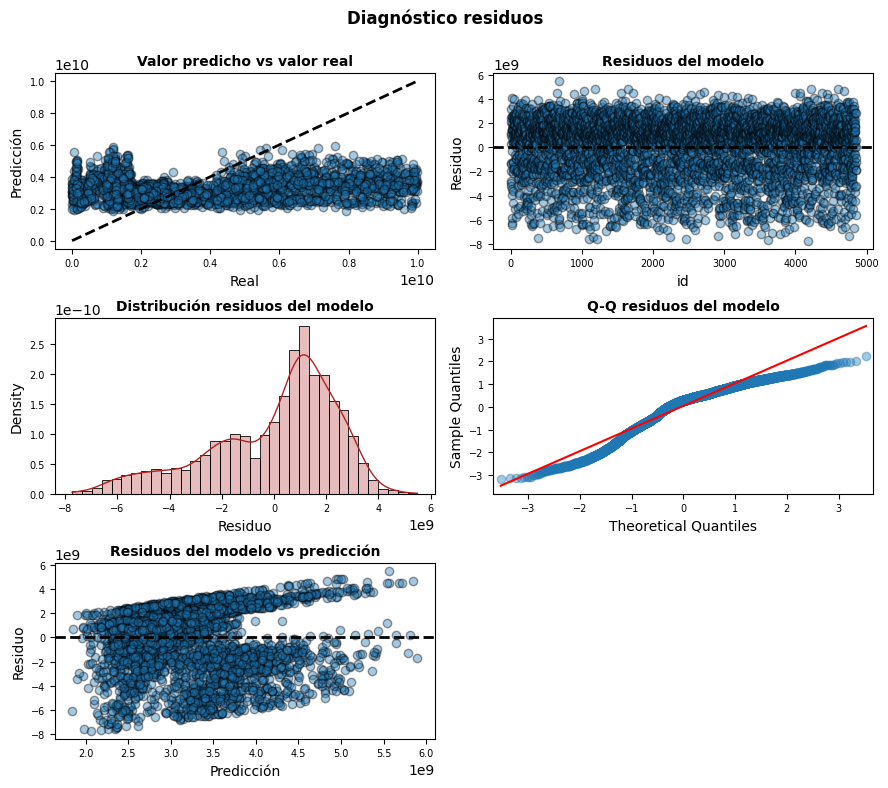

In [ ]:
# DIVISION
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# CREAR MODELO Y ENTRENAMIENTO
X_train = sm.add_constant(X_train, prepend=True)
modelo = sm.OLS(endog=y_train, exog=X_train,)
modelo = modelo.fit()
print(modelo.summary())

# Intervalos de confianza para los coeficientes del modelo
# ==============================================================================
intervalos_ci = modelo.conf_int(alpha=0.05)
intervalos_ci.columns = ['2.5%', '97.5%']
print(intervalos_ci)

# Diagnostico de Errores
# ==============================================================================
y_train_flatten = y_train.values.flatten()
prediccion_train = modelo.predict(exog = X_train)
residuos_train   = prediccion_train - y_train_flatten
diagnostic_garbages(y_train_flatten, prediccion_train,residuos_train)

                            OLS Regression Results                            
Dep. Variable:               TOTAL KW   R-squared:                       0.060
Model:                            OLS   Adj. R-squared:                  0.060
Method:                 Least Squares   F-statistic:                     154.5
Date:                Sun, 13 Nov 2022   Prob (F-statistic):           8.55e-66
Time:                        20:05:50   Log-Likelihood:            -1.1179e+05
No. Observations:                4854   AIC:                         2.236e+05
Df Residuals:                    4851   BIC:                         2.236e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        3.775e+09   1.07e+08     35.338      

C:\Users\Gimena\AppData\Local\Temp\ipykernel_9328\2440019341.py:12: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  axes[0, 0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()],
c:\Users\Gimena\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\graphics\gofplots.py:1045: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


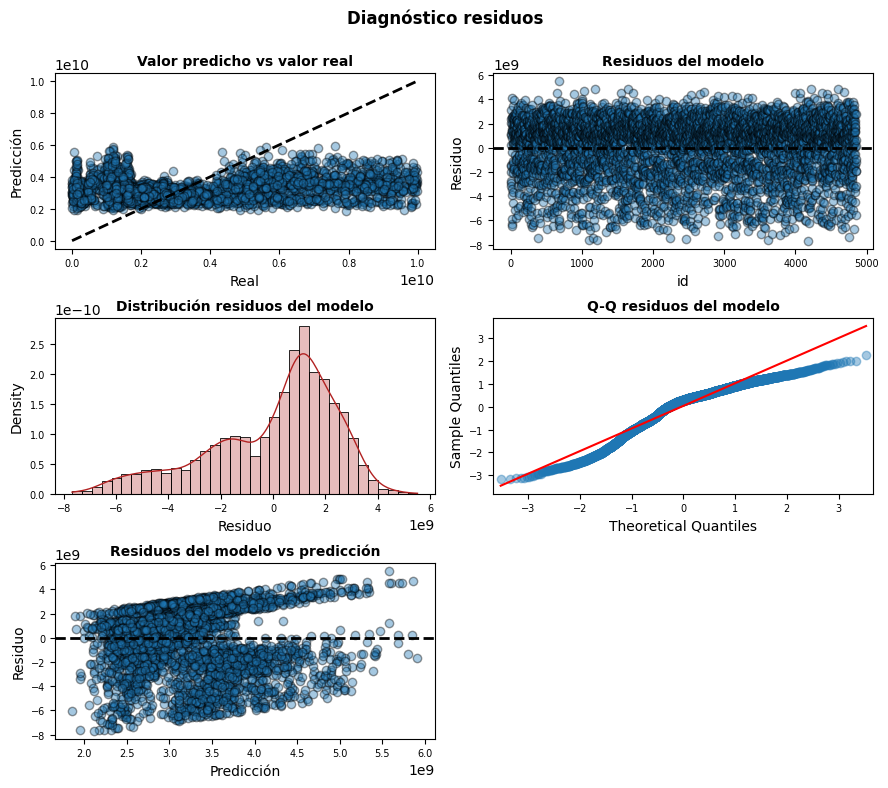

In [ ]:
# EVALUANDO QUITANDO LAS COLUMNAS DE MENOR PESO
# A la matriz de predictores se le tiene que añadir una columna de 1s para el intercept del modelo
X_train_2 = X_train.drop(columns=['Feriado', 'Dia'])
X_test_2 = X_test.drop(columns=['Feriado', 'Dia'])
X_train_2 = sm.add_constant(X_train_2, prepend=True)
modelo_clear_1 = sm.OLS(endog=y_train, exog=X_train_2,)
modelo_clear_1 = modelo_clear_1.fit()
print(modelo_clear_1.summary())

# Intervalos de confianza para los coeficientes del modelo
# ==============================================================================
intervalos_ci = modelo_clear_1.conf_int(alpha=0.05)
intervalos_ci.columns = ['2.5%', '97.5%']
print("\n" + "INTERVALO DE CONFIANZA" +"\n")
print(intervalos_ci)
print("\n" + "######################" +"\n")

# Diagnostico de Errores
# ==============================================================================
y_train_flatten = y_train.values.flatten()
prediccion_train = modelo_clear_1.predict(exog = X_train_2)
residuos_train   = prediccion_train - y_train_flatten
diagnostic_garbages(y_train_flatten, prediccion_train,residuos_train)